In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn
import copy

import ase.io

from utils.librascal import RascalSphericalExpansionTorch, TorchFrame
from utils.models.soap import compute_power_spectrum

In [3]:
frames = ase.io.read("data/molecule_conformers_dftb.xyz", ":100")

# frames = ase.io.read("selection-10k.extxyz", "::100")
for frame in frames:
    frame.cell = [100, 100, 100]
    frame.center()

training_frames_np, testing_frames_np = sklearn.model_selection.train_test_split(
    frames, train_size=0.8, random_state=0XDEADBEEF, 
)

del frames

train_energies = torch.tensor([
    frame.info["energy"] for frame in training_frames_np
])

train_forces = torch.vstack([
    torch.tensor(frame.arrays["forces"]) for frame in training_frames_np
])

test_energies = torch.tensor([
    frame.info["energy"] for frame in testing_frames_np
])

test_forces = torch.vstack([
    torch.tensor(frame.arrays["forces"]) for frame in testing_frames_np
])

# transform frames from numpy to torch:
training_frames = [TorchFrame(frame, requires_grad=True) for frame in training_frames_np]
testing_frames = [TorchFrame(frame, requires_grad=True) for frame in testing_frames_np]

In [4]:
RASCAL_HYPERS = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 6,
    "gaussian_sigma_type": "Constant",
}

def compute_spherical_expansion(frames, forward_gradients=False):
    hypers = copy.deepcopy(RASCAL_HYPERS)
    hypers["compute_gradients"] = True
    # TODO: forward grad
    
    calculator = RascalSphericalExpansionTorch(hypers)
    return calculator.compute(frames)

# Check Kernels vs librascal

In [5]:
from utils.models.utils import dot, power, structure_sum, normalize

check_frames = training_frames[::10]
check_frames_np = training_frames_np[::10]

spx = compute_spherical_expansion(check_frames)
ps = compute_power_spectrum(spx)

ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps.keys_to_samples('center_species')
ps = normalize(ps)
kernel = power(dot(ps, ps), zeta=2)

structure_kernel = structure_sum(kernel, sum_properties=True)

In [6]:
from rascal.representations import SphericalInvariants
from rascal.models import Kernel as RascalKernel

rascal_calculator = SphericalInvariants(
    normalize=True, 
    soap_type="PowerSpectrum", 
    **RASCAL_HYPERS
)
managers = rascal_calculator.transform(check_frames_np)

rascal_ps = managers.get_features(rascal_calculator)
rascal_kernel_per_atom = np.power(rascal_ps @ rascal_ps.T, 2)
rascal_kernel = np.zeros((len(check_frames_np), len(check_frames_np)))

start_i = 0
for i, frame_1 in enumerate(check_frames_np):
    stop_i = start_i + len(frame_1)
    
    start_j = 0
    for j, frame_2 in enumerate(check_frames_np):
        stop_j = start_j + len(frame_2)
        rascal_kernel[i, j] = np.sum(rascal_kernel_per_atom[start_i:stop_i, start_j:stop_j])
        start_j = stop_j

    start_i = stop_i
        

# This is using mean instead of sum for reduction
# rascal_kernel_fn = RascalKernel(
#     rascal_calculator, 
#     name="Cosine", 
#     kernel_type="Full",
#     target_type="Structure",
#     zeta=1
# )

In [7]:
torch_kernel = structure_kernel.block().values.detach().numpy()

assert np.allclose(rascal_kernel, torch_kernel)

# Training models

In [8]:
def rmse(actual, predicted):
    return torch.sqrt(torch.mean((actual.flatten() - predicted.flatten())**2))

def parity_plot(energies, predicted_energies, forces, predicted_forces):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    loss = rmse(energies, predicted_energies)
    x = [energies.min(), energies.max()]
    ax[0].plot(x, x, color="r")
    ax[0].scatter(energies, predicted_energies)
    ax[0].set_title(f"Energy — RMSE = {1000 * loss:.4} meV")

    loss = rmse(forces.flatten(), predicted_forces.flatten())
    x = [forces.flatten().min(), forces.flatten().max()]
    ax[1].plot(x, x, color="r")
    ax[1].scatter(forces.flatten(), predicted_forces.flatten())
    ax[1].set_title(f"Forces — RMSE = {1000 * loss:.4} meV/A")

In [9]:
def check_finite_differences(model, frame, delta=1e-6, keys_to_samples=True):
    frame = frame.copy()
    torch_frame = TorchFrame(frame, requires_grad=True)

    spx = compute_spherical_expansion([torch_frame])
    ps = compute_power_spectrum(spx)
    ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
    if keys_to_samples:
        ps.keys_to_samples('center_species')
    energy, _ = model.predict(ps, with_forces=False)

    forces, = torch.autograd.grad(
        outputs=energy, 
        grad_outputs=-torch.ones_like(energy), 
        inputs = torch_frame.positions
    )

    frame.positions[3, 1] += delta
    torch_frame = TorchFrame(frame, requires_grad=True)
    spx_delta = compute_spherical_expansion([torch_frame])
    ps_delta = compute_power_spectrum(spx_delta)
    ps_delta.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
    if keys_to_samples: 
        ps_delta.keys_to_samples('center_species')

    energy_delta, _ = model.predict(ps_delta, with_forces=False)

    finite_diff = - (energy_delta[0, 0] - energy[0, 0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", forces[3, 1].item())

In [10]:
train_spx = compute_spherical_expansion(training_frames)
train_ps = compute_power_spectrum(train_spx)
train_ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
train_ps.keys_to_samples('center_species')


test_spx = compute_spherical_expansion(testing_frames)
test_ps = compute_power_spectrum(test_spx)
test_ps.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
test_ps.keys_to_samples('center_species')


# train_spx_no_grad = compute_spherical_expansion(training_frames, gradients=False)
# train_ps_no_grad = compute_power_spectrum(train_spx_no_grad)
# train_ps_no_grad.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
# train_ps_no_grad.sparse_to_samples('center_species')


# test_spx_no_grad = compute_spherical_expansion(testing_frames, gradients=False)
# test_ps_no_grad = compute_power_spectrum(test_spx_no_grad)
# test_ps_no_grad.sparse_to_features(['neighbor_species_1', 'neighbor_species_2'])
# test_ps_no_grad.sparse_to_samples('center_species')

## Train a linear regression model

In [11]:
from utils.models.linear import LinearModel

In [12]:
model = LinearModel(normalize=True, regularizer=[1e-4, 5e-4])

model.fit(train_ps, train_energies)

In [13]:
check_finite_differences(model, testing_frames_np[0], delta=1e-6)

finite difference = -0.21823205997861805
computed gradient = -0.21821962296962738


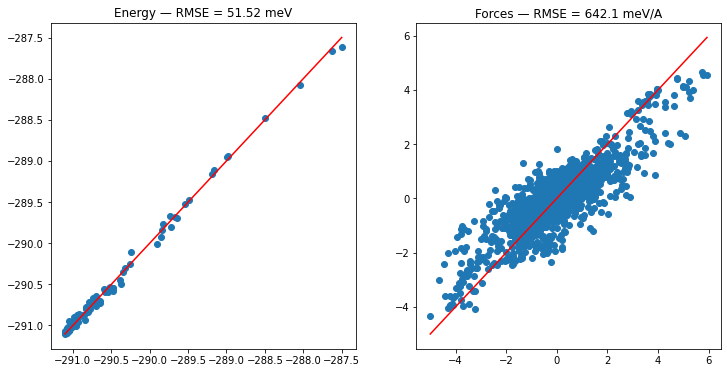

In [14]:
predicted_energy, _ = model.predict(train_ps, with_forces=False)

for frame in training_frames:
    frame.positions.grad = None

# we need retain_graph=True to retain the frame => ps part of the graph
predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted_energy.detach(), train_forces, predicted_forces)

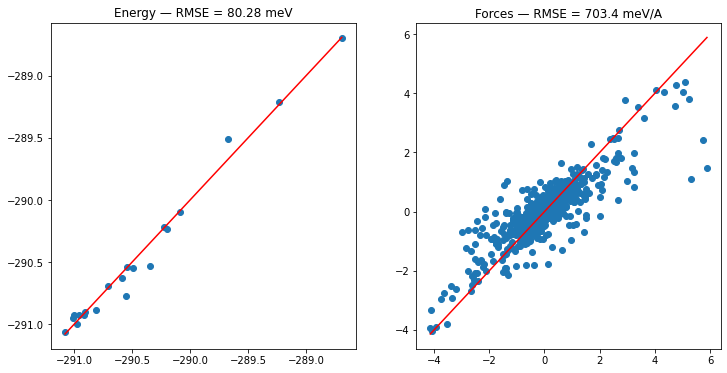

In [15]:
predicted_energy, _ = model.predict(test_ps, with_forces=False)

for frame in testing_frames:
    frame.positions.grad = None

predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted_energy.detach(), test_forces, predicted_forces)

## Train a GAP model with full kernel

In [16]:
from utils.models.full_kernel import FullKernelGap

In [17]:
model = FullKernelGap(zeta=2, regularizer=[1e-2, 1e-2])

model.fit(train_ps, train_energies)

In [18]:
check_finite_differences(model, testing_frames_np[0], delta=1e-6)

finite difference = -0.23768603796270327
computed gradient = -0.23767653107643127


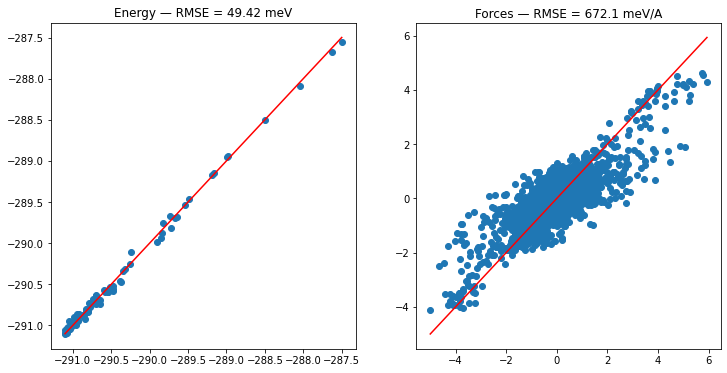

In [19]:
predicted_energy, _ = model.predict(train_ps, with_forces=False)

for frame in training_frames:
    frame.positions.grad = None

predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted_energy.detach(), train_forces, predicted_forces)

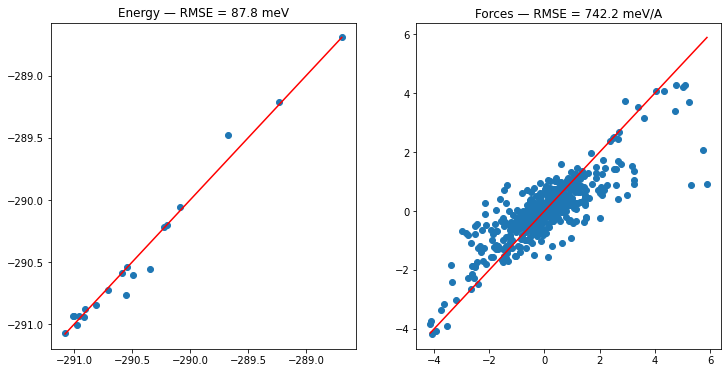

In [20]:
predicted_energy, _ = model.predict(test_ps, with_forces=False)

for frame in testing_frames:
    frame.positions.grad = None

predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted_energy.detach(), test_forces, predicted_forces)

# Sparse kernels

In [21]:
from utils.models.sparse_kernel import select_support_points, SparseKernelGap

In [22]:
support = select_support_points(train_ps, n_select=80)

print(support.block().values.shape)

torch.Size([80, 1512])


In [23]:
model = SparseKernelGap(support_points=support, zeta=2, regularizer=[1e-2, 5e-2])

model.fit(train_ps, train_energies)

In [24]:
check_finite_differences(model, testing_frames_np[0], delta=1e-6)

finite difference = 0.07405299129459308
computed gradient = 0.07407233864068985


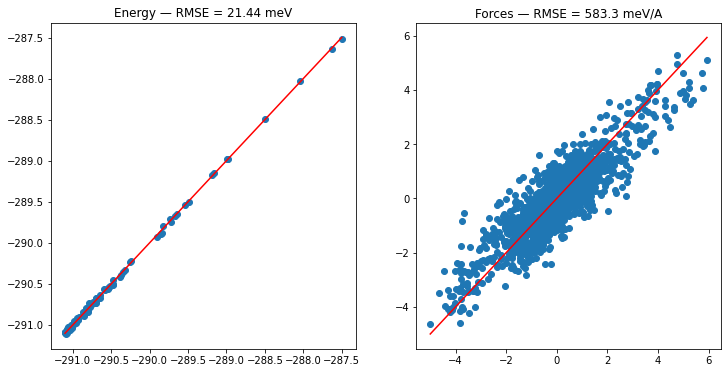

In [25]:
predicted_energy, _ = model.predict(train_ps, with_forces=False)

for frame in training_frames:
    frame.positions.grad = None


predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted_energy.detach(), train_forces, predicted_forces)

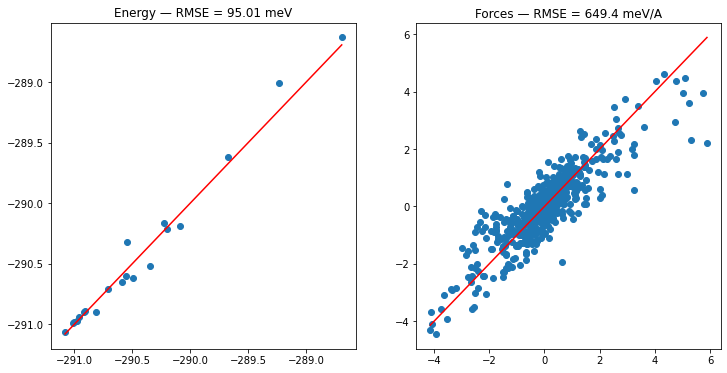

In [26]:
predicted_energy, _ = model.predict(test_ps, with_forces=False)

for frame in testing_frames:
    frame.positions.grad = None

predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted_energy.detach(), test_forces, predicted_forces)

## Sparse kernel with different support point per central species

In [28]:
train_ps_per_species = compute_power_spectrum(train_spx)
train_ps_per_species.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])

test_ps_per_species = compute_power_spectrum(test_spx)
test_ps_per_species.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])

In [32]:
n_select = {
    center_species: 0
    for center_species in train_ps_per_species.keys.as_namedtuples()
}

n_select[(1,)] = 30
n_select[(6,)] = 30
n_select[(8,)] = 20

support = select_support_points(train_ps_per_species, n_select=n_select)

In [33]:
model = SparseKernelGap(support_points=support, zeta=2, regularizer=[1e-2, 1e-2])

model.fit(train_ps_per_species, train_energies)

In [35]:
check_finite_differences(model, testing_frames_np[0], delta=1e-6, keys_to_samples=False)

finite difference = -0.05695471827493748
computed gradient = -0.056936927139759064


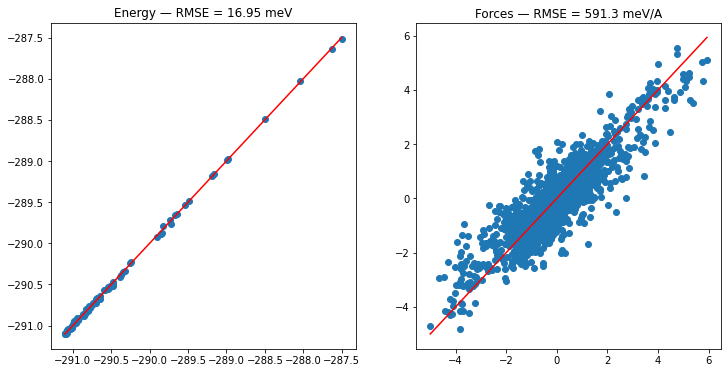

In [36]:
predicted_energy, _ = model.predict(train_ps_per_species, with_forces=False)

for frame in training_frames:
    frame.positions.grad = None


predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in training_frames])

parity_plot(train_energies, predicted_energy.detach(), train_forces, predicted_forces)

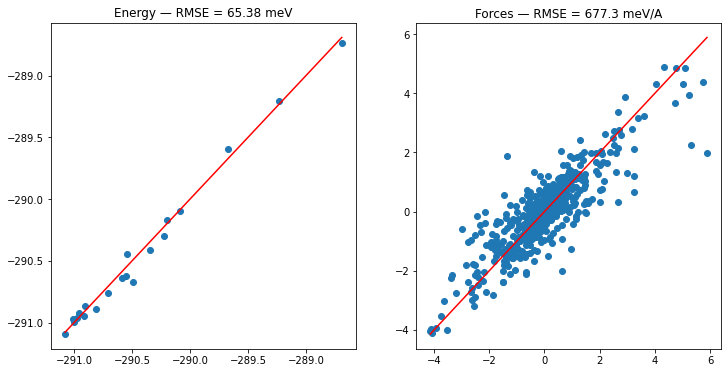

In [37]:
predicted_energy, _ = model.predict(test_ps_per_species, with_forces=False)

for frame in testing_frames:
    frame.positions.grad = None

predicted_energy.backward(-torch.ones_like(predicted_energy), retain_graph=True)
predicted_forces = torch.vstack([frame.positions.grad for frame in testing_frames])

parity_plot(test_energies, predicted_energy.detach(), test_forces, predicted_forces)